# Ames Housing Dataset

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)

The dataset contains 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. It is a complete dataset if compared to the traditional Boston Housing Dataset commonly used for Data Science tutorials. The Ames Housing dataset was compiled by Dean De Cock for use in data science education.

In here an initial data analysis is performed to guide the next steps. The most relevant points learned from this data analysis are:

* A strategy to handle the null values must be trialled. KNN, mean values replacement and MICE strategies need to be tested
* There are features that are highly correlated. They could be removed or combined to simplify the dataset
* Skewed variables are present.  Feature transformation can be used to improve model performance, mainly if ANN or SVM are used
* From the feature analysis, it was possible to obtain ideas for new features that could improve model performance

In [1]:
# Code you have previously used to load data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import MaxNLocator
import missingno as msno

# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

# Initial Data Import

In [2]:
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = '../input/train.csv'
iowa_test_file_path = '../input/test.csv'

home_data = pd.read_csv(iowa_file_path)
home_data_test = pd.read_csv(iowa_test_file_path)
# Create target object and call it y
SalePrice = home_data.iloc[:,-1]
SalePriceTest = home_data_test.iloc[:,-1]

In [3]:
# Create 
home_data['YearBuilt'] = home_data['YearBuilt'].astype(int)
home_data['YrSold'] = home_data['YrSold'].astype(int)

Features = home_data.copy()
Features_test = home_data_test.copy()

Features.drop(['Id','SalePrice'], axis=1, inplace=True)
Features_test.drop ('Id', axis=1, inplace=True)

In [4]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))
    
def bar_plot(x,y,xlabel,ylabel,title):
    plt.figure(figsize=(20,5))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.barplot(x=x, y = y, palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=70,fontsize = 12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)

    for p in ax.patches:
                 ax.annotate("%.d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
                     ha='center', va='center', color='black', xytext=(0, 10),
                     textcoords='offset points')

def Null_Analysis(df,title):
    null_columns=df.columns[df.isnull().any()]
    null_columns_plot = df[null_columns].isnull().sum().sort_values(ascending = False)
    bar_plot(null_columns_plot.index, null_columns_plot,"Features", "Number of Null Values", title)

# Part 1 - EDA

Initial Analysis to understand dataset size, number of features, null and duplicated entries:

In [5]:
basic_EDA(Features)

Number of Samples: 1460,
Number of Features: 79,
Duplicated Entries: 0,
Null Entries: 6965,
Number of Rows with Null Entries: 1460 100.0%


In [6]:
basic_EDA(Features_test)

Number of Samples: 1459,
Number of Features: 79,
Duplicated Entries: 0,
Null Entries: 7000,
Number of Rows with Null Entries: 1459 100.0%


## Null Values Analysis

From the previous output, it becomes clear that handling the null values is going to be one of the top priorities. More detailed information about the missing values can be obtained by plotting the missing values per features and using the MSNO package to understand the relationship between the missing variables.

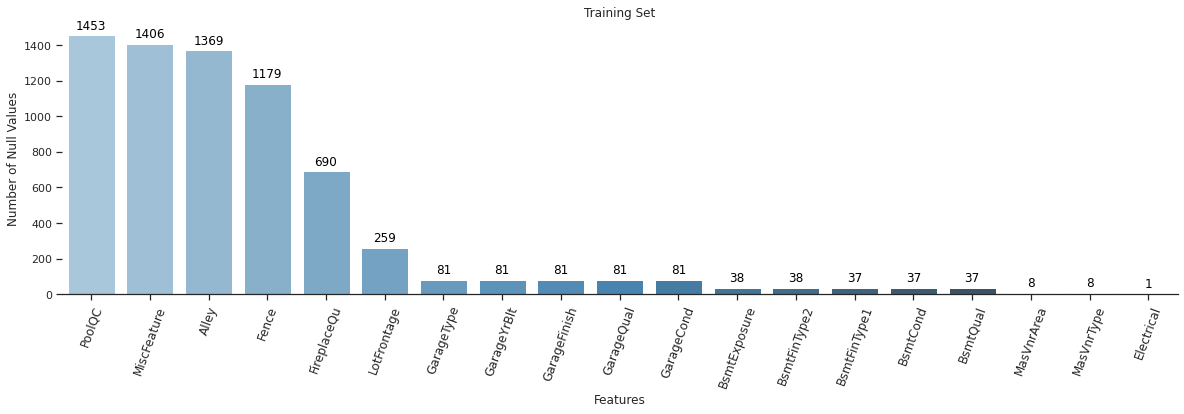

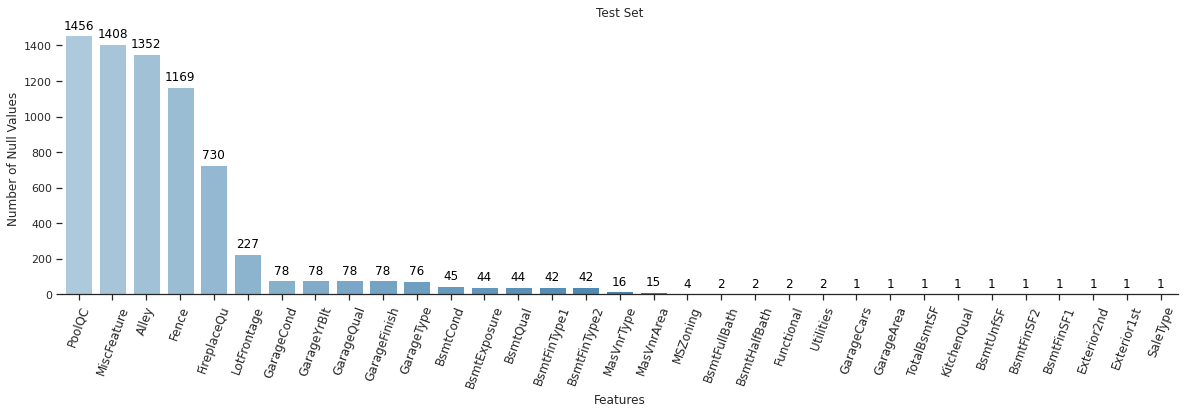

In [7]:
Null_Analysis(Features, "Training Set")
Null_Analysis(Features_test, "Test Set")

There are plenty of missing values. At this point, we can conclude that eliminating the rows with null values is not an option as it would include too many samples. Plausible options are the following:

* Understand the impact of eliminating the Features with too many null values for train and test set, e.g. PoolQC, MiscFeature

* Replacement of the null values. This can be done by using the average, median, KNN or MICE strategies. It will be necessary to try and check the best method for each feature

<AxesSubplot:>

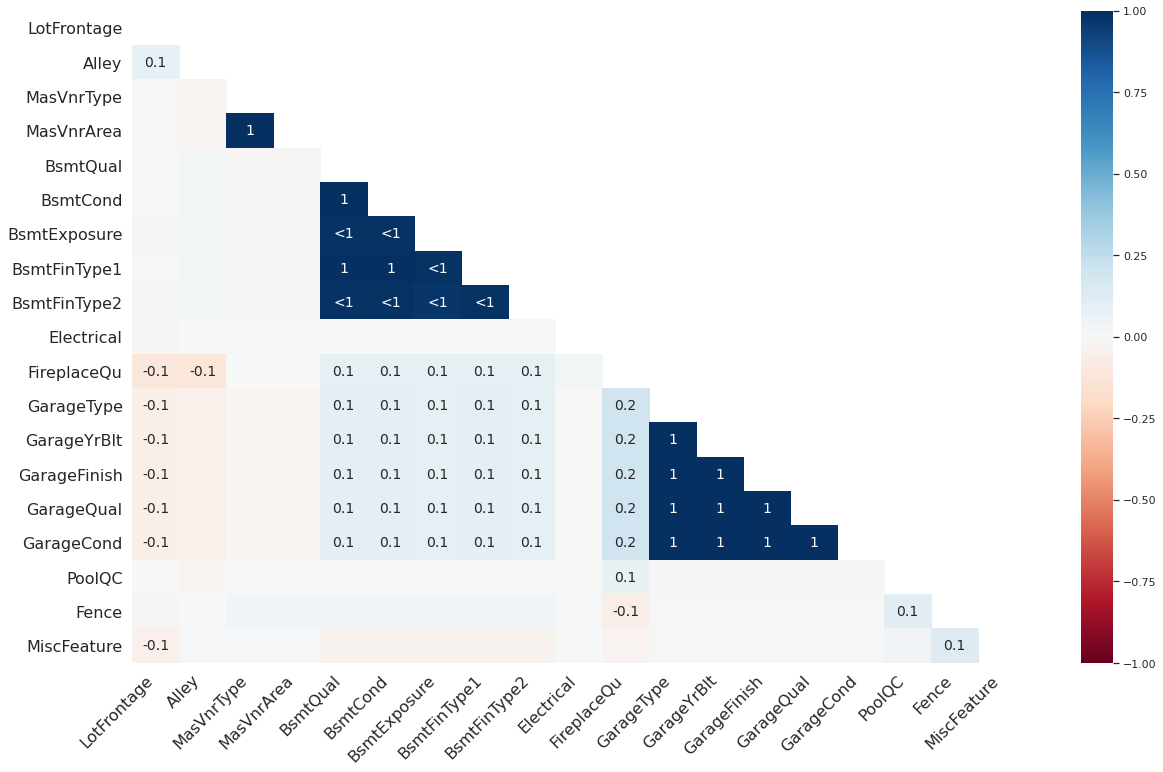

In [8]:
msno.heatmap(home_data)

The above correlation matrix from the MSNO package helps us understand the relationship between the missing variables. In this analysis, features that present strong correlation signifies that when that specific feature is missing, the other is also likely to be missing. Negative values represent the reverse relationship; if one is missing, the other is likely to be present. 

We see strong relationships within the garage features, which makes sense since if one variable related to the garage is missing, it is likely that garage information is lacking for that property. A similar cluster is formed for the features related to the basement.

## Graphical Analysis

As we already analysed the null values and predefined a strategy to handle them, it is now time to understand the features of the dataset. Scatter plots, KDE, Correlation and Box Plots can provide useful information and are shown next.

In [9]:
#Separate in Numerical and Categorical Variables
numeric_data = Features.select_dtypes(include=[np.number])
numeric_data_test = Features_test.select_dtypes(include=[np.number])

categorical_data = Features.select_dtypes(exclude=[np.number])
categorical_data_test = Features_test.select_dtypes(exclude=[np.number])

numeric_features = numeric_data.columns

## Numerical Features Analysis 

First, we start by analysing the numerical data. Then we use box plots to visualise the categorical features.

KDE plots are great to understand the distribution of the variables as well as compare the distribution of the training and test sets. Ideally, all sets should have a similar distribution so that improvements obtained on the training and validation set are likely to be replicated on the test set. 

The set of graphs below provided the following insights:

* Several features are skewed, a strategy to apply some feature transformation can be helpful to improve model performance
* Some features are continuous, however, shapes such as OverallCond indicate discrete variables. A more apparent distinction between discrete and continuous features can be visualised by using Scatter Plots
* The train and test sets provided have a similar distribution, which will make our life easier when testing different approaches

<Figure size 432x288 with 0 Axes>

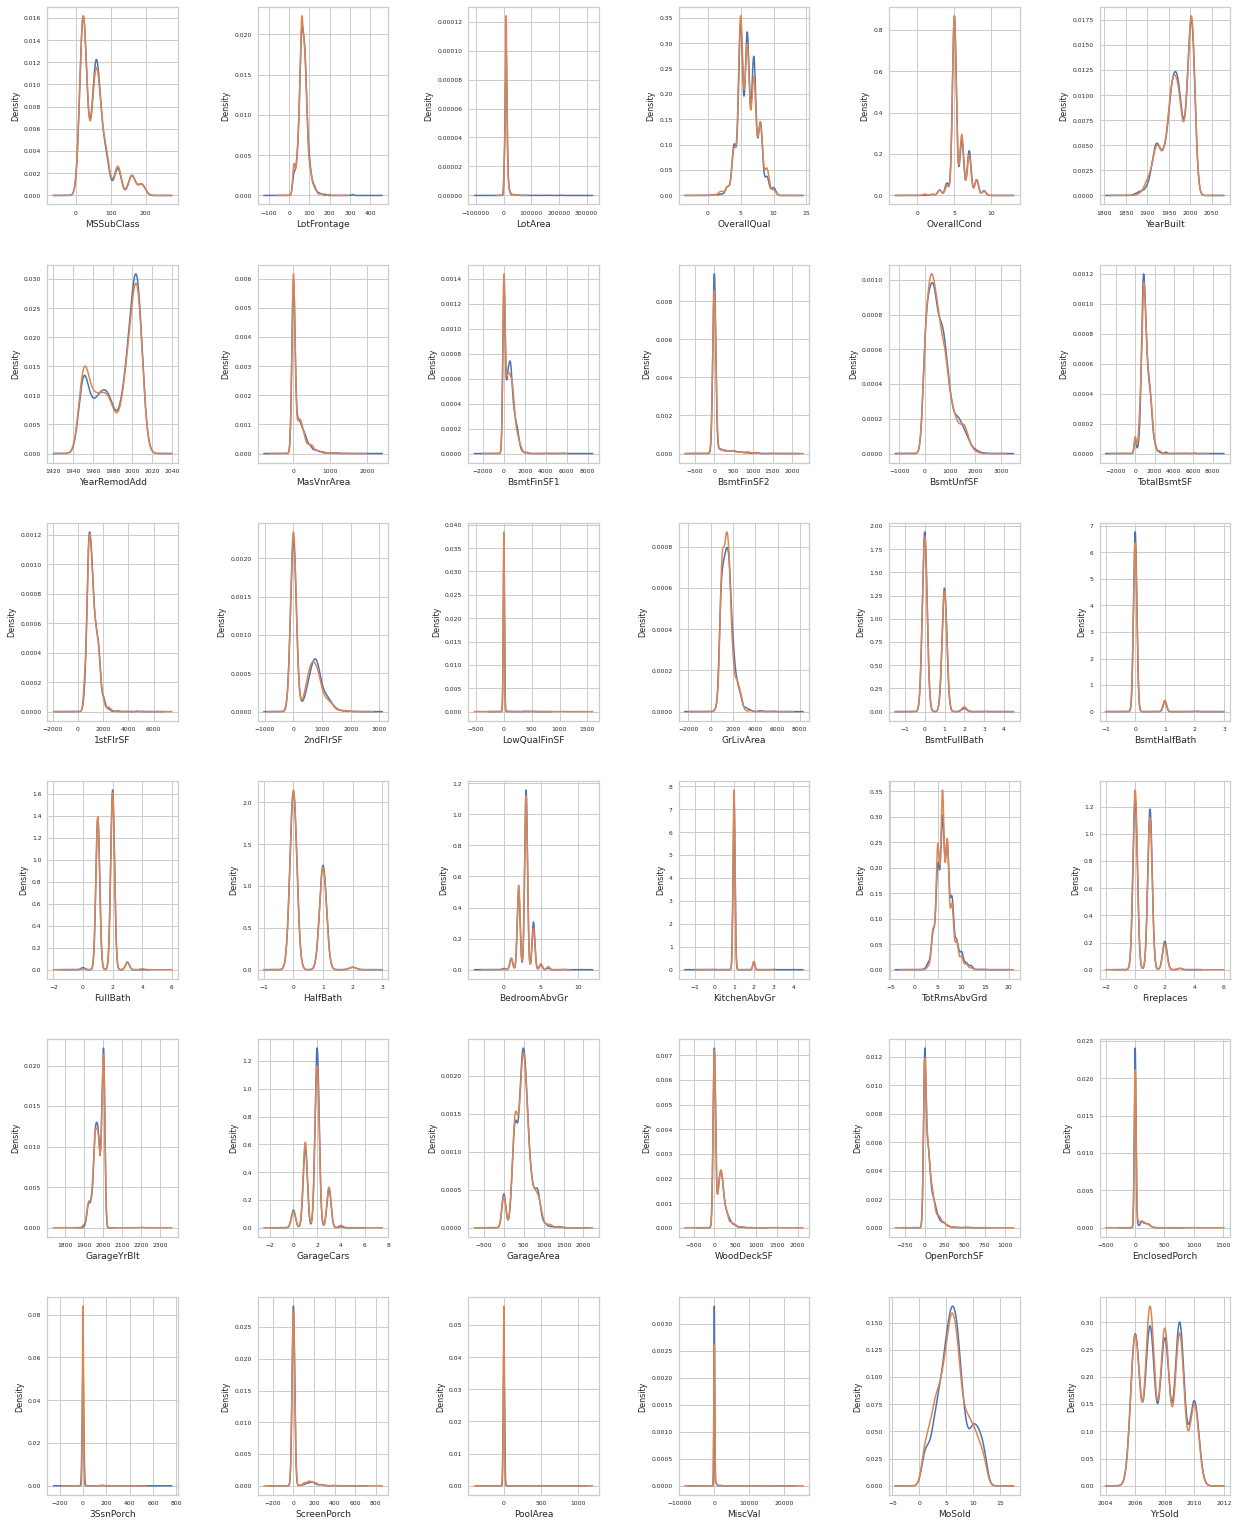

In [10]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(6,6,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(6,6,i)
        df1[feature].plot.kde()
        df2[feature].plot.kde()
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad = 0)
        plt.tick_params(axis='y', which='major', labelsize=6, pad = 0)
        plt.ylabel("Density",fontsize=8)
    fig.tight_layout(pad=3.0)
    plt.show();
    
plot_feature_distribution(numeric_data, numeric_data_test, "Train", "Test", numeric_features)    

<Figure size 432x288 with 0 Axes>

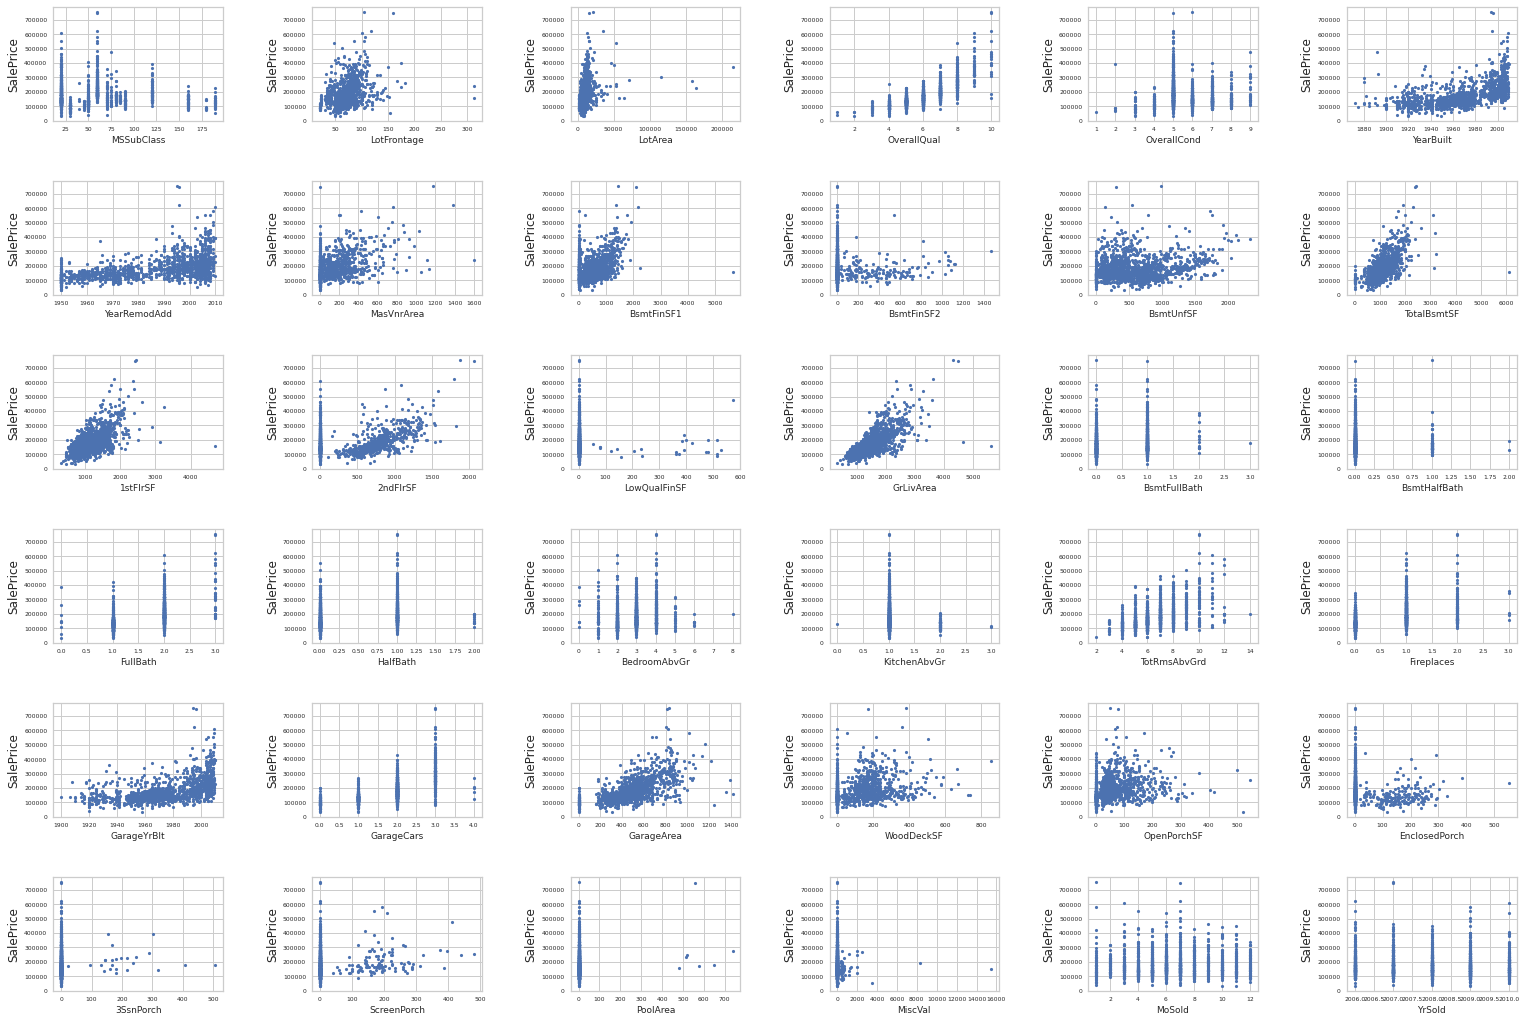

In [11]:
def plot_reg(df1, label1, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(6,6,figsize=(22,15))

    for feature in features:
        i += 1
        plt.subplot(6,6,i)
        sns.scatterplot(x = df1[feature], y = "SalePrice",data=home_data,linewidth=0,s=10)
        #df2[feature].plot.kde()
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad = 0)
        plt.tick_params(axis='y', which='major', labelsize=6, pad = 0)
        #plt.ylabel("Density",fontsize=8)
    fig.tight_layout(pad=3.0)
    plt.show();
    
plot_reg(home_data, "Train", numeric_features)

From the plots above, it is possible to obtain the following insights from this dataset:
* The idea to plot the training and test sets KDE on top of each other is to verify their similarity. There is no point on training the data within a widely different variable range from the test set. When possible, make sure the training and test sets have similar distributions, as it is likely that the strategies that improve the training set will also have a positive effect on the test set.
* The KDE plots shapes support identification of skewed variables, see LotFrontage for example. This analysis is relevant as later we can attempt to transform skewed variables into a more Gaussian distribution to improve the ML models prediction capability. Variable transformation is appropriate, especially when using ANN or SVM, as they are more sensitive to skewed data (if compared to model tree's). As a downside, features and target variables transformation (log, exp, power) may affect the interpretability of the results; however, this is not a concern on this competition. 
* While the KDE plots can provide some intuition regarding which variables are Discrete or Continuous, the scatter plots offer a more precise insight for the task. From the scatter plots, it is straightforward to identify the Discrete (e.g. OverallQual, YrSold, OverallCond) and Continuous (e.g. LotFrontage, LotArea, GrLiveArea) variables. For the House Market dataset is easy to identify such characteristics even by the variable name. However, in real-life sometimes is not that easy, and this analysis comes in handy as discrete and continuous variables can be analysed differently.
* Regarding the scatter plots for the continuous variables. Scatter shapes such as the GrLivArea, GarageArea or 1stFlrSF are usually helpful as they present an almost linear dependency to the target, SalePrice. As such, these variables will also have a higher correlation value to the SalePrice. This is because correlation is only able to capture linear relationships. 
* Additionally, see how EnclosedPorch and BsmtFinSF2 have almost an exponential shape. Perhaps some kind of transformation can be helpful here as well, as we can also note from their KDE graph which is also highly skewed. For other variables, the dependency is not as obvious, such as for OPenPorchSF or MsVnrArea. It does not mean that they are not relevant to the model, since we will use non-linear models, they will be able to capture such behaviour. 
* For the Discrete variables, we can also use box plots to analyse their effect on the SalePrice better. The Discrete Features we can identify from the scatter plot are: *MsSubClass, OverallQual, OverallCond, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, GarageCars, MoSold, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, YrSold*

In [12]:
def boxplot_disc(y, df):
    fig, axes = plt.subplots(5, 3, figsize=(25, 25))
    axes = axes.flatten()

    for i, j in zip(df.columns[:-1], axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,y=y,data=df,palette='Blues_d',order=sortd.index,ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

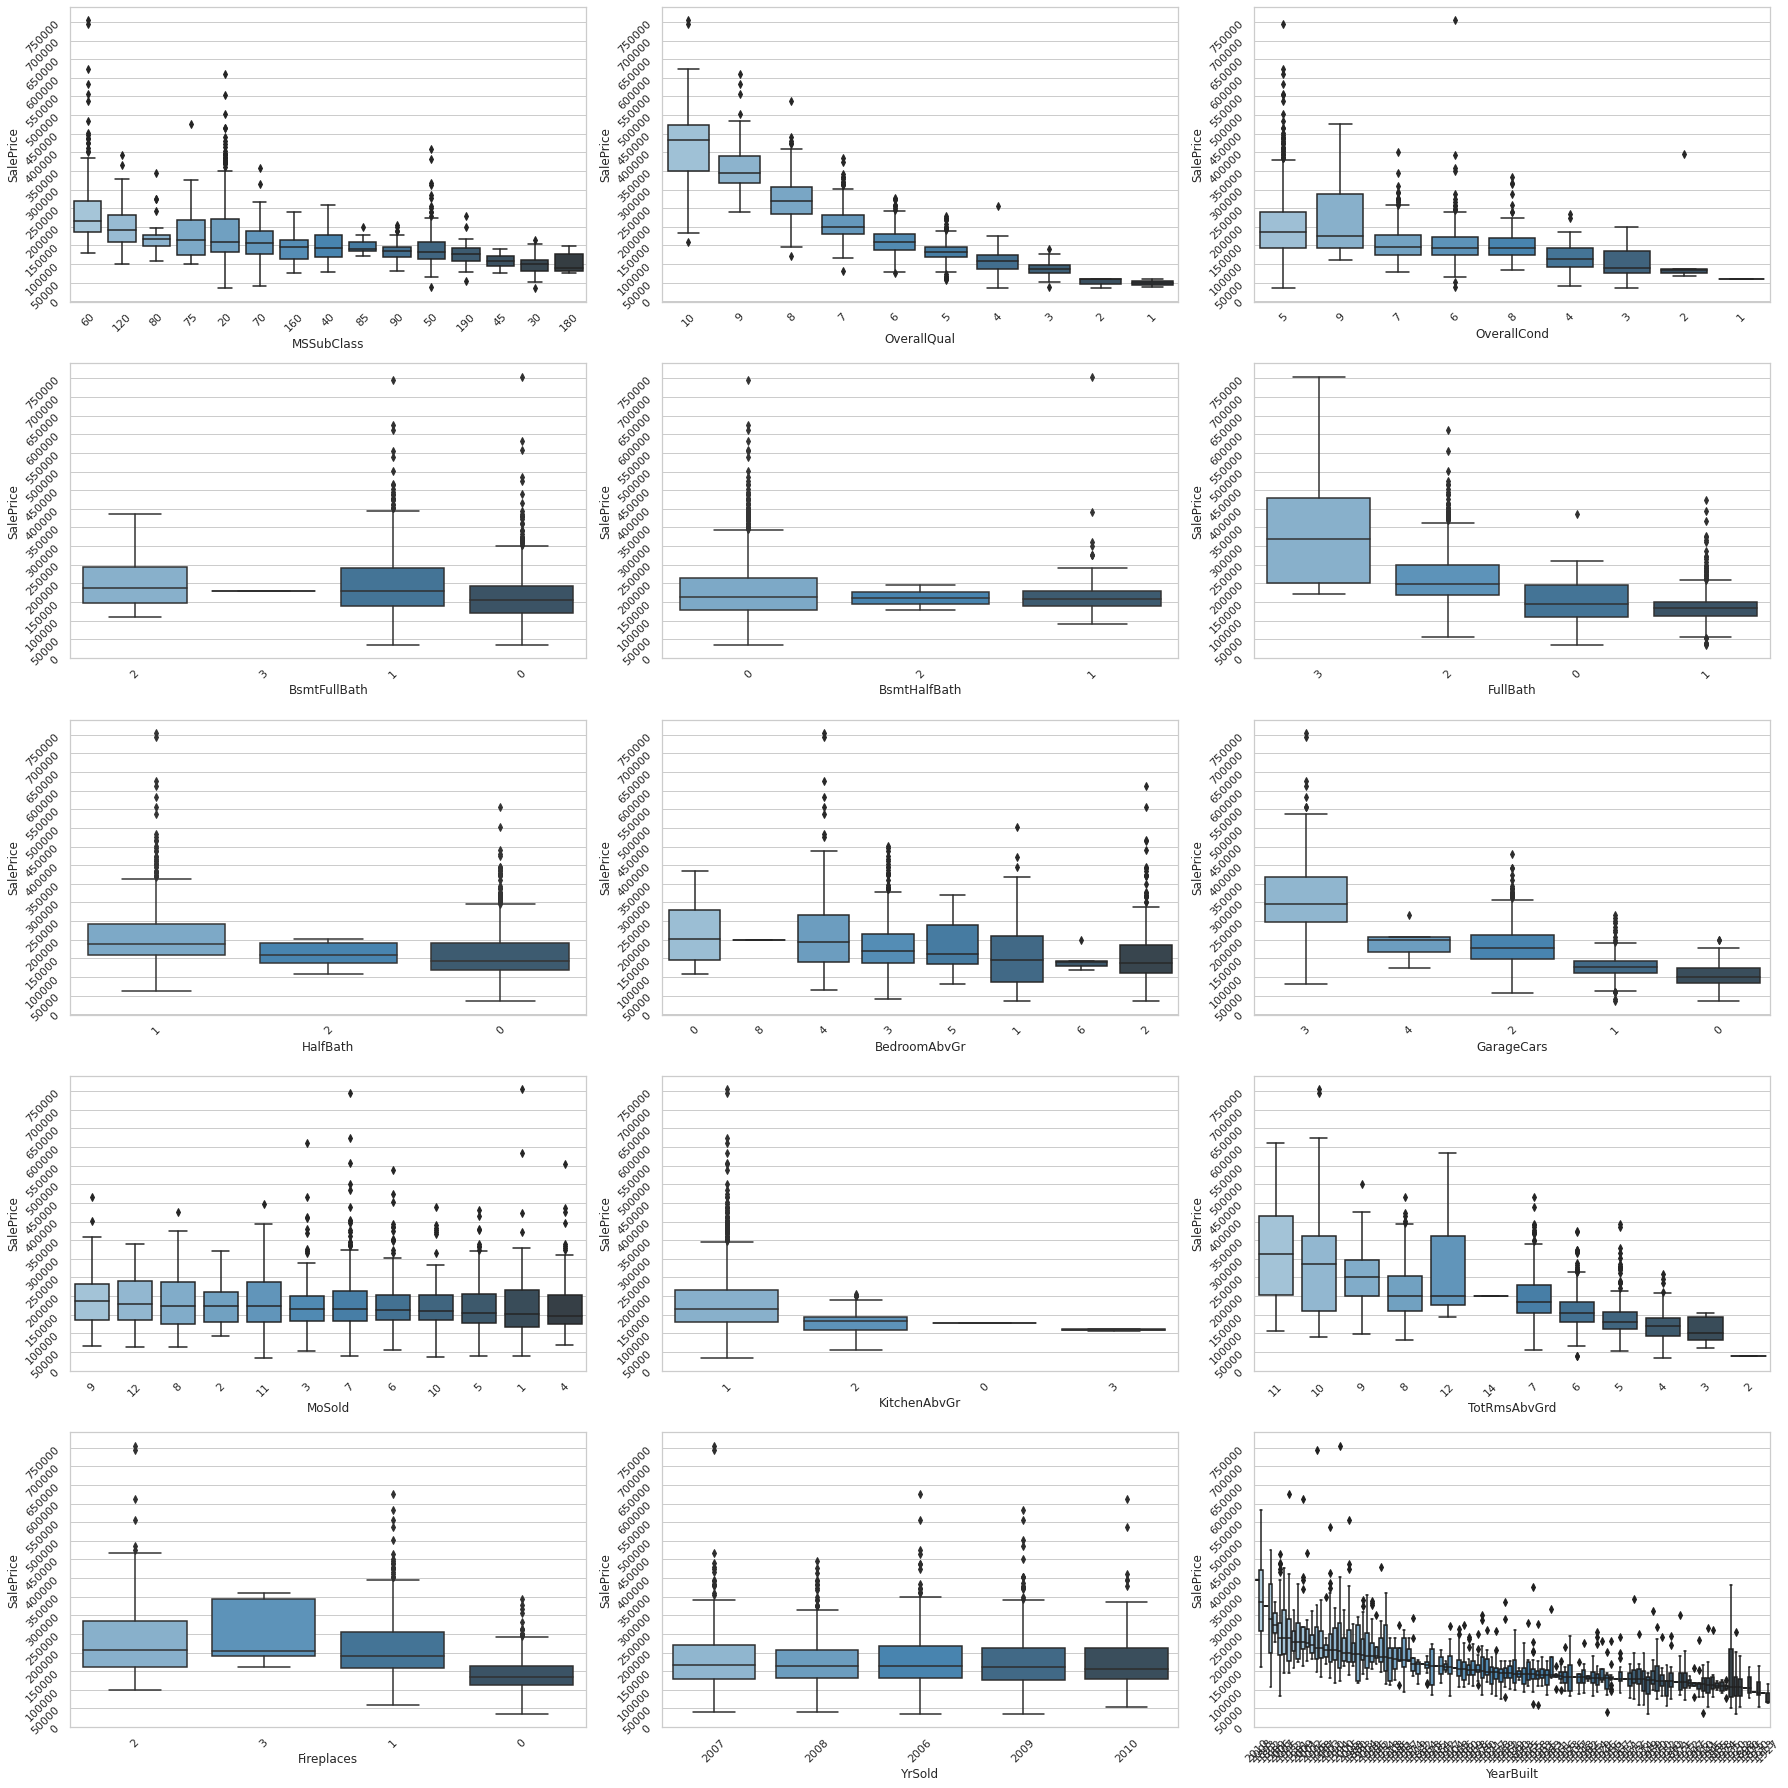

In [13]:
DiscreteNumeric = home_data.loc[:,['MSSubClass','OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','GarageCars','MoSold','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','YrSold','YearBuilt','SalePrice']]
boxplot_disc('SalePrice', DiscreteNumeric)

* It is interesting how the variable OverallQual seems to affect the price much more than OverallCond. For example, on average houses marked with score 7 or higher for OverallQual have been sold for US 225k. The same analysis cannot be performed by OverallCond as they mean values are quite within the same range.
* Similar to OverallCond, many other variables do not seem to affect the average price as much. In contrast, the variables FullBath, GarageCars and TotRmsAbvGrd do show a clear variability of the average house price according to their value.

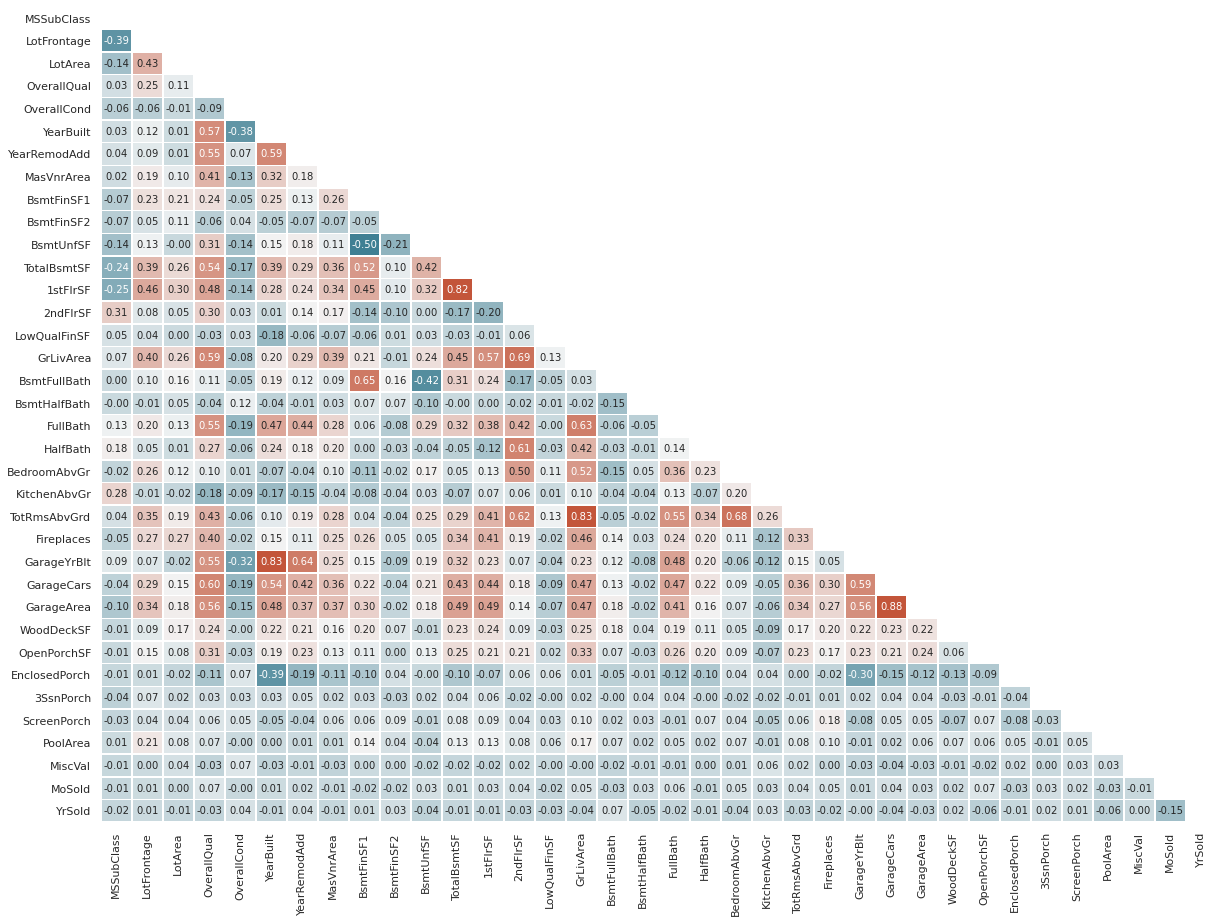

In [14]:
cm = sns.diverging_palette(220, 20, sep=5, as_cmap=True)
corr = numeric_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,15))
    ax = sns.heatmap(corr, mask=mask, vmin = -0.5, vmax=0.8, linewidths=.5,annot=True,fmt=".2f",cmap = cm,annot_kws={"size": 10},cbar=False)

As mentioned earlier, the correlation only measures the linear relationship between two variables. For this reason, I do not believe that the correlation between the variables and target is **that** helpful.  As it is a linear relationship measurement, the correlation is not always a valid strategy to discard variables as most applications will contain non-linear dependences between the variables. 

We can also use the correlation plot to better understand the data. Note in the plot above a few clusters. For this dataset, it is easy to understand the "why" of these clusters. For example, GarageYrBlt, GarageCars and GarageArea show a higher correlation to OverallQual, YearBuilt and YearRemodAdd. It is relatively straight forward to understand why the year the garage was built is positively correlated to the year the house was built, which probably also impacts the current quality of the house (OverallQual). Such analysis is interesting to understand the dataset, which variables are affected by what and even understand which variables could be made redundant.

When dealing with large datasets and an incredibly high number of features, one strategy to remove features is to analyse their correlation value. There is an argument that adding two variables that are highly correlated to each other do not add meaningful information to the model, using only one of them would suffice. For example, we can see how GarageArea and GarageCars are highly correlated (0.88). As more extensive garage area fits more cars, one of them could be removed to make a leaner model. 

Main take-away:

* Highly correlated features could be removed 

## Categorical Features Analysis

Next we analyse the categorical features also using the Box Plot. Insights regarding the house prices and the different categories of each variables can be extracted.

In [15]:
def boxplot(y, df):
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,y=y,data=df,palette='Blues_d',order=sortd.index,ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

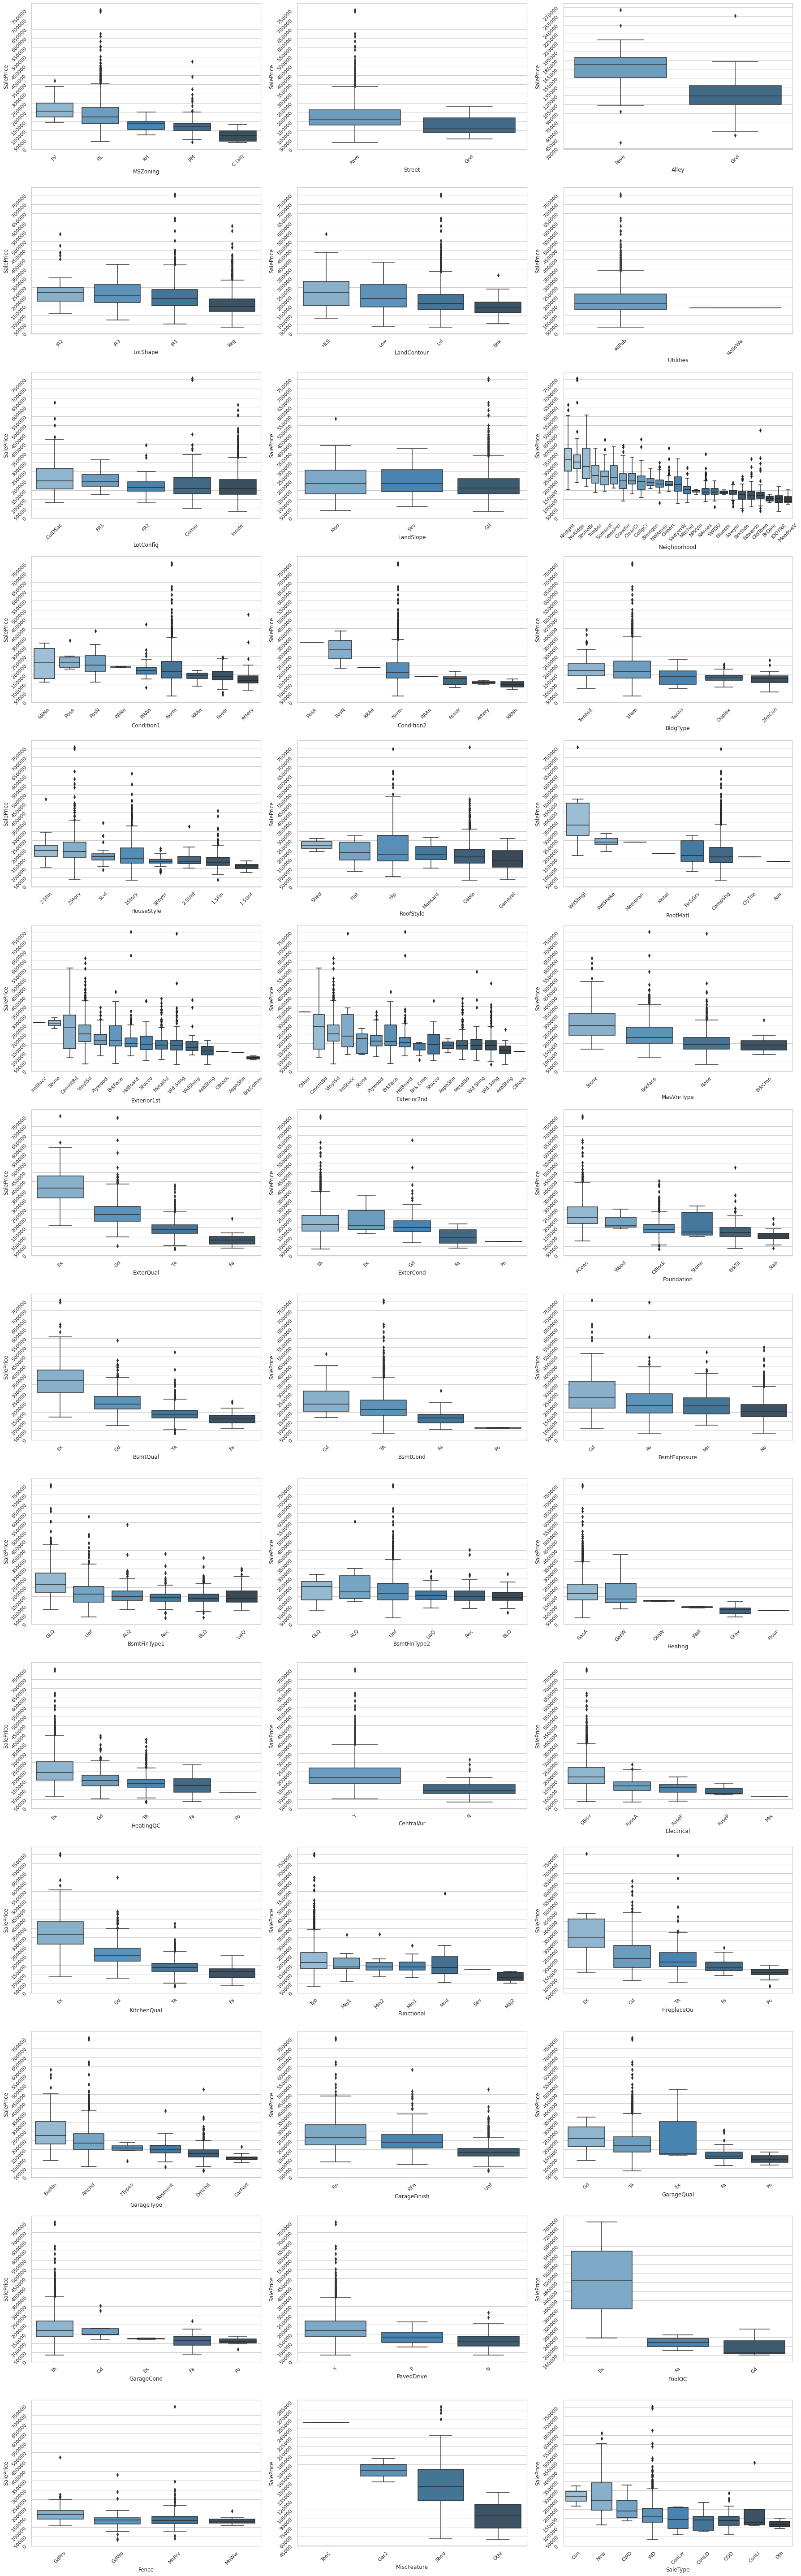

In [16]:
boxplot('SalePrice', home_data)

Regarding the Categorical features, the following categories caught my attention as they are related to higher house prices: 
* Alley as "Pave", 
* Condition2 as "PosN"
* RoofMatl as "WdShngl"
* MasVnrType as "Stone"
* ExterQual as "Ex"
* BsmtQual as "Ex"
* KitchenQual as "Ex"
* FireplaceQu as "Ex"
* PoolQc as "Ex".

Analysing the Categorical and Discrete variables, ideas regarding new features start to pop-up. 

For example, the boxplot analysis has shown that on average the houses with excellent conditions were sold with higher prices. Therefore a new feature could count how many "Ex" (as excellent) or "Po" (as poor) quality markers a house has scored. A similar thing can be done by grouping the neighbourhood with similar average prices. Features such as "has a Fireplace" or "has a Pool" can also be derived from the existing features and can potentially help the model predictions. 

This concludes our initial EDA. In Part 2, we analyse how to handle the missing values, perform feature engineering and variable transformation. 

**Please, consider to upvote if you found this helpful.**